In [18]:
import numpy as np 
import progressbar
from GPyOpt.methods import BayesianOptimization

In [19]:
# honest network delay over next n blocks.
def vectorDelayHonest(ps, es, init_endorsers, delay_priority, delay_endorse):
    return (60 * len(ps)
           + delay_priority * sum(ps) 
           + sum([delay_endorse * max(init_endorsers - e, 0) for e in es]))

# attacking network delay over next n blocks.
def vectorDelayAttacker(ps, es, init_endorsers, delay_priority, delay_endorse):
    return (60 * len(ps) 
           + delay_priority * sum(ps) 
           + sum([delay_endorse * max(init_endorsers - e, 0) for e in es[1:]]))

# efficient sample generation
def getAH(alpha):
    x = np.random.geometric(1-alpha)
    if x == 1:
        h = 0
        a = np.random.geometric(alpha)
    else:
        a = 0
        h = x - 1
    return [a, h]

def rewardBlock(p, e):
    if p == 0:
        return e * 1.25
    return e * 0.1875

def rewardEndorsement(p):
    if p == 0:
        return 1.25
    return 0.8333333

def calcHonestSingle(p, e):
    if p == 0:
        return rewardBlock(0, 32) + e * rewardEndorsement(0)
    return e * rewardEndorsement(0)

def calcAttackSingle(p, e):
    return rewardBlock(p, e) + e * rewardEndorsement(p)

def vectorRewardHonest(ps, es):
    totalReward = 0
    for i in range(len(ps)):
        totalReward += calcHonestSingle(ps[i], es[i])
    return totalReward

def vectorRewardAttack(ps, es):
    totalReward = calcAttackSingle(ps[0], 32)
    for i in range(1,len(ps)):
        totalReward += calcAttackSingle(ps[i], es[i])
    return totalReward

def calcCosts(ps, es):
    return vectorRewardHonest(ps, es) - vectorRewardAttack(ps, es)

In [20]:
def getProbReorg(alpha, length, init_endorsers, delay_priority, delay_endorse, sample_size = int(1e5)):
    bar = progressbar.ProgressBar()
    feasible_count = 0
    for _ in range(sample_size):
        aVals = []
        hVals = []
        for i in range(length):
            a, h = getAH(alpha)
            aVals.append(a)
            hVals.append(h)
        eVals = np.random.binomial(32, alpha, size = length)
        honest_delay = vectorDelayHonest(hVals, 32 - eVals, init_endorsers, delay_priority, delay_endorse)
        selfish_delay = vectorDelayAttacker(aVals, eVals, init_endorsers, delay_priority, delay_endorse)
        if selfish_delay <= honest_delay:
            feasible_count += 1
    return feasible_count / sample_size

In [21]:
# May not be correct
def getProbSelfish(alpha, length, sample_size = int(1e5), init_endorsers = 24, delay_priority = 40, delay_endorse = 8):
    bar = progressbar.ProgressBar()
    feasible_count = 0
    for _ in bar(range(sample_size)):
        aVals = []
        hVals = []
        for i in range(length):
            a, h = getAH(alpha)
            aVals.append(a)
            hVals.append(h)
        eVals = np.random.binomial(32, alpha, size = length)
        honest_delay = vectorDelayHonest(hVals, 32 - eVals, init_endorsers, delay_priority, delay_endorse)
        selfish_delay = vectorDelayAttacker(aVals, eVals, init_endorsers, delay_priority, delay_endorse)
        if (selfish_delay <= honest_delay) and (calcCosts(aVals, eVals) < 0):
            feasible_count += 1
    return feasible_count / sample_size

In [22]:
# maximization
weights_alphas = [(1.0, 0.3), (0.8, 0.35), (0.6, 0.4), (0.4, 0.45), (0.2, 0.49)]

# Only looking at reorg for now
def combined(alpha, length, sample_size = int(1e4), init_endorsers = 24, delay_priority = 40, delay_endorse = 8):
    return getProbReorg(alpha, length, init_endorsers, delay_priority, delay_endorse, sample_size) 
    # + getProbSelfish(alpha, length, sample_size, init_endorsers, delay_priority, delay_endorse)

def objective(inputs):
    return -sum([weight * combined(alpha = alpha, length = 20, init_endorsers = inputs[0][0], delay_priority = inputs[0][1], delay_endorse = inputs[0][2]) for (weight, alpha) in weights_alphas])
domain = [{'name': 'init_endorsers', 'type': 'discrete', 'domain': tuple(range(33))}, 
        {'name': 'delay_priority', 'type': 'discrete', 'domain': tuple(range(100))}, 
        {'name': 'delay_endorse', 'type': 'discrete', 'domain': tuple(range(100))}]

opt = BayesianOptimization(f = objective, domain = domain)
opt.run_optimization(max_iter = 100)

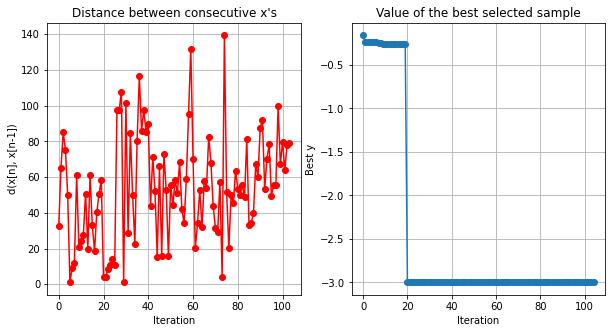


X = [init_endorsers delay_priority delay_endorse]

All tested values of X : 
[[11. 71. 95.]
 [ 8. 52. 69.]
 [10.  3. 26.]
 [20. 78. 65.]
 [14.  3. 62.]
 [ 8. 52. 69.]
 [ 8. 51. 69.]
 [ 0. 53. 73.]
 [ 0. 53. 61.]
 [ 0. 58.  0.]
 [ 0. 79.  0.]
 [21. 67.  0.]
 [ 0. 64. 18.]
 [32. 99.  0.]
 [12. 99.  0.]
 [32. 41.  0.]
 [ 0. 33.  0.]
 [14. 45.  0.]
 [32. 81.  0.]
 [ 0. 46. 17.]
 [32.  0.  0.]
 [28.  0.  0.]
 [31.  0.  3.]
 [24.  3.  7.]
 [30.  9.  0.]
 [17.  4.  0.]
 [27.  0.  0.]
 [30. 23. 95.]
 [ 0. 97. 39.]
 [26.  0.  0.]
 [27.  1.  0.]
 [ 7. 26. 96.]
 [29. 12. 84.]
 [31.  4.  0.]
 [22.  7. 49.]
 [24. 11. 27.]
 [22. 89.  9.]
 [14. 12. 96.]
 [14. 87. 54.]
 [ 2.  6.  1.]
 [ 9. 69. 58.]
 [23.  2.  0.]
 [ 2.  8. 38.]
 [12. 51. 94.]
 [30. 17. 59.]
 [24. 28. 50.]
 [18. 93. 40.]
 [27. 92. 27.]
 [ 9. 27. 55.]
 [ 6. 73. 29.]
 [12. 61. 37.]
 [24. 31. 82.]
 [19. 75. 82.]
 [ 6. 89. 27.]
 [16. 90. 77.]
 [19. 61. 15.]
 [31. 74. 53.]
 [ 0. 82. 41.]
 [ 0. 23. 40.]
 [31. 92. 98.]
 [23.  1.  3.]
 [18. 3

In [23]:
opt.plot_convergence()
print("\nX = [init_endorsers delay_priority delay_endorse]")
print("\nAll tested values of X : \n" + str(opt.X))
print("\nCorresponding values of Y : \n" + str(opt.Y))
print("\nOptimal X : \n" + str(opt.x_opt))
print("\nOptimal Y : \n" + str(objective([opt.x_opt])))
print("\nCurrent Tezos : \n" + str(objective([[24, 40, 8]])))